In [9]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


^C


Looking in indexes: https://download.pytorch.org/whl/cu118, https://pypi.ngc.nvidia.com


In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
import os
from PIL import Image
import random

d:\College\keshi\Text2ImageGen\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU Name: NVIDIA GeForce RTX 3060


In [3]:
import os
import torch

BASE_DIR = r"D:\College\keshi\Text2ImageGen"
CHECKPOINT_PATH = r"D:\College\keshi\Text2ImageGen\scripts\unet_epoch_4.pt"

REAL_IMG_DIR = os.path.join(BASE_DIR, "scripts", "milestone3_results", "real_images")
GEN_IMG_DIR = os.path.join(BASE_DIR, "scripts", "milestone3_results", "generated_images")
GEN_IMG_CHEK = os.path.join(BASE_DIR, "scripts", "milestone3_results", "generated_images_check")    

os.makedirs(REAL_IMG_DIR, exist_ok=True)
os.makedirs(GEN_IMG_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [4]:
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch

print("Loading Stable Diffusion base model...")

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None
)

print("Loading fine-tuned UNet weights from training checkpoint...")

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

# Extract only the actual model weights
unet_weights = checkpoint["model_state_dict"]

pipe.unet.load_state_dict(unet_weights, strict=False)

pipe = pipe.to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

print("✅ Fine-tuned model successfully loaded")


Loading Stable Diffusion base model...


Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading fine-tuned UNet weights from training checkpoint...
✅ Fine-tuned model successfully loaded


100%|██████████| 30/30 [01:41<00:00,  3.38s/it]


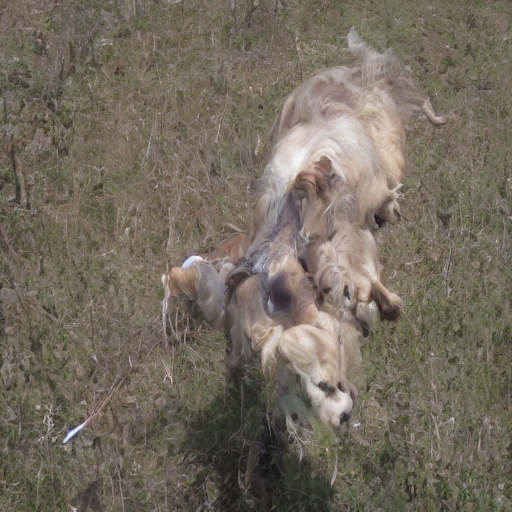

In [5]:
test_prompt = "A golden retriever playing  in green field"

image = pipe(
    test_prompt,
    guidance_scale=7.5,
    num_inference_steps=30
).images[0]

image


In [9]:
import os
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
from PIL import Image
import random

# Explicitly enable hf_xet for Hugging Face
os.environ["HF_HUB_ENABLE_HF_XET"] = "1"

print("Loading Flickr30K validation set using hf_xet acceleration...")

dataset = load_dataset(
    "lmms-lab/flickr30k",
    split="test",
    storage_options={"use_xet": True}
)

SAMPLE_SIZE = 100
sampled = random.sample(range(len(dataset)), SAMPLE_SIZE)

#for idx, i in enumerate(sampled):
    #img = dataset[i]["image"]
    #img.save(os.path.join(REAL_IMG_DIR, f"real_{idx}.png"))

#print(f"{SAMPLE_SIZE} real images saved to {REAL_IMG_DIR} using hf_xet")


Loading Flickr30K validation set using hf_xet acceleration...


In [10]:
print("Generating images for evaluation...")

prompts = [dataset[i]["caption"][0] for i in sampled]

#for idx, prompt in enumerate(prompts):
#    image = pipe(
#        prompt,
#        guidance_scale=7.5,
#        num_inference_steps=30
#    ).images[0]
    
    #image.save(os.path.join(GEN_IMG_DIR, f"gen_{idx}.png"))

#print(f"{SAMPLE_SIZE} generated images saved to {GEN_IMG_DIR}")


Generating images for evaluation...


In [11]:
print("Sample prompt that generated strange image:\n")
print(prompts[0])


Sample prompt that generated strange image:

Two men on a pier have caught a large fish in a net  and three other people gaze from the background .


In [15]:
!pip install torchmetrics pytorch-fid scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from pytorch_fid import fid_score

print("Computing FID Score (safe mode)...")

fid_value = fid_score.calculate_fid_given_paths(
    [REAL_IMG_DIR, GEN_IMG_DIR],
    batch_size=1,       # safer for Windows
    device=device,
    dims=2048,
    num_workers=0       # CRITICAL FIX
)

print(f"✅ FID Score: {fid_value:.4f}")


Computing FID Score (safe mode)...


100%|██████████| 44/44 [00:03<00:00, 11.05it/s]


✅ FID Score: 381.9514


In [13]:
!pip install torch-fidelity


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from torchmetrics.image.inception import InceptionScore
import torch
from PIL import Image
import os
import numpy as np

print("Computing Inception Score (correct dtype)...")

inception_metric = InceptionScore(splits=10).to(device)

for img_file in os.listdir(GEN_IMG_DIR):
    img_path = os.path.join(GEN_IMG_DIR, img_file)
    
    img = Image.open(img_path).convert("RGB")
    img = img.resize((299, 299))

    img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).unsqueeze(0)
    img_tensor = img_tensor.to(device)

    inception_metric.update(img_tensor)

inception_mean, inception_std = inception_metric.compute()

print(f"✅ Inception Score: {inception_mean:.4f} ± {inception_std:.4f}")


Computing Inception Score (correct dtype)...
✅ Inception Score: 2.7083 ± 0.2227


In [22]:
import pandas as pd

results = pd.DataFrame({
    "Metric": ["FID", "Inception Score"],
    "Value": [fid_value, float(inception_mean)]
})

results.to_csv(r"D:\College\keshi\Text2ImageGen\scripts\milestone3_results\evaluation_scores.csv", index=False)
results


,Metric,Value
0,FID,381.951436
1,Inception Score,2.708340


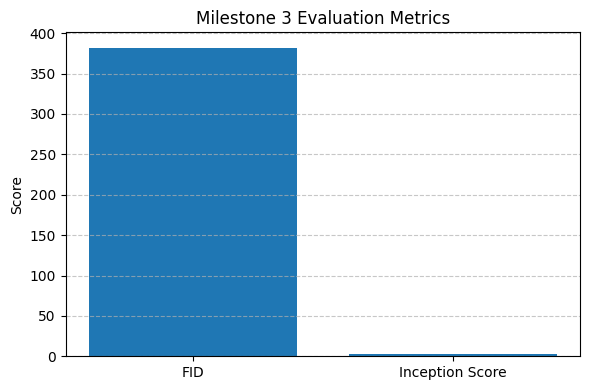

In [24]:
import matplotlib.pyplot as plt

metrics = ["FID", "Inception Score"]
values = [fid_value, inception_mean.cpu().numpy()]

plt.figure(figsize=(6,4))
plt.bar(metrics, values)
plt.title("Milestone 3 Evaluation Metrics")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("D:\College\keshi\Text2ImageGen\scripts\milestone3_results\metrics_plot.png")
plt.show()

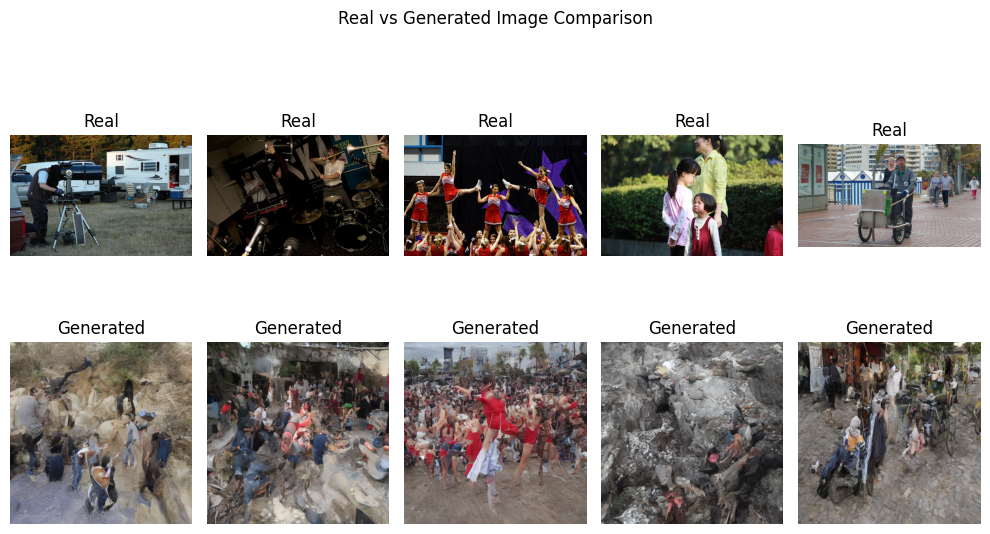

In [20]:
import matplotlib.pyplot as plt

real_imgs = sorted(os.listdir(REAL_IMG_DIR))[:5]
gen_imgs = sorted(os.listdir(GEN_IMG_DIR))[:5]

plt.figure(figsize=(10,6))

for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(Image.open(os.path.join(REAL_IMG_DIR, real_imgs[i])))
    plt.axis("off")
    plt.title("Real")

    plt.subplot(2,5,i+6)
    plt.imshow(Image.open(os.path.join(GEN_IMG_DIR, gen_imgs[i])))
    plt.axis("off")
    plt.title("Generated")

plt.suptitle("Real vs Generated Image Comparison")
plt.tight_layout()
plt.show()


In [21]:
print("=== Milestone 3 Quantitative Results ===")
print(f"FID Score: {fid_value:.4f}")
print(f"Inception Score: {inception_mean:.4f} ± {inception_std:.4f}")

if fid_value < 30:
    quality = "Strong alignment model"
elif fid_value < 50:
    quality = "Moderate alignment model"
else:
    quality = "Weak alignment model"

print(f"Evaluation Conclusion: {quality}")


=== Milestone 3 Quantitative Results ===
FID Score: 381.9514
Inception Score: 2.7083 ± 0.2227
Evaluation Conclusion: Weak alignment model
